In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # Our hero ^_^
import statsmodels.api as sm

df = pd.read_csv('MavenRail_cleaned2.csv')

#Data structure#
df.head(10)
df.info()
df.shape
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30686 entries, 0 to 30685
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Payment.Method     30686 non-null  object
 1   Railcard           10359 non-null  object
 2   Ticket.Class       30686 non-null  object
 3   Ticket.Type        30686 non-null  object
 4   Price              30686 non-null  int64 
 5   Departure.Station  30686 non-null  object
 6   Arrival.Station    30686 non-null  object
 7   Departure          30683 non-null  object
 8   Scheduled.Arrival  30682 non-null  object
 9   Actual.Arrival     28851 non-null  object
 10  Journey.Status     30686 non-null  object
 11  Reason.for.Delay   4121 non-null   object
 12  Refund.Request     30686 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.0+ MB


Index(['Payment.Method', 'Railcard', 'Ticket.Class', 'Ticket.Type', 'Price',
       'Departure.Station', 'Arrival.Station', 'Departure',
       'Scheduled.Arrival', 'Actual.Arrival', 'Journey.Status',
       'Reason.for.Delay', 'Refund.Request'],
      dtype='object')

<Axes: >

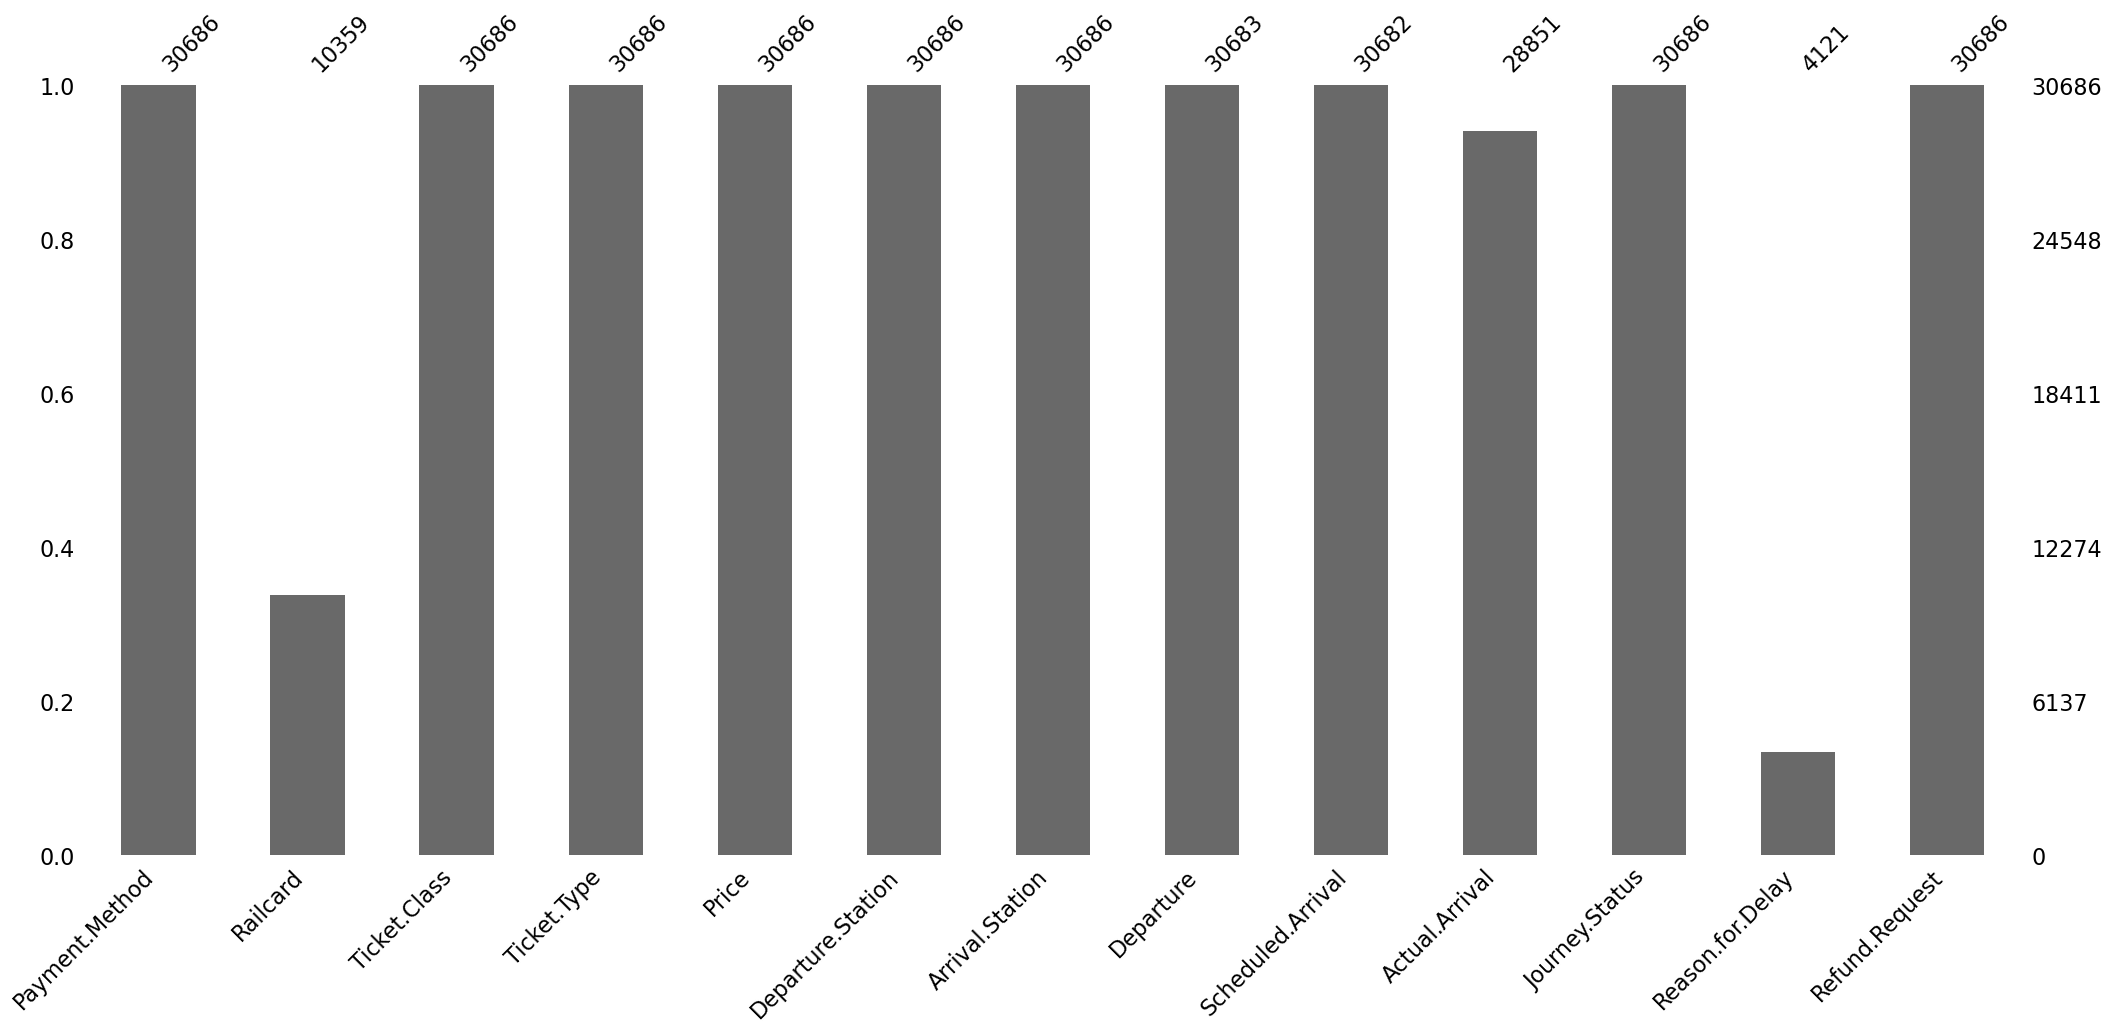

In [26]:
#Missing Values

df.isna().sum()
msno.bar(df)

In [27]:
#Data Summary Stats
df.describe()
df.describe(include='object')


,Payment.Method,Railcard,Ticket.Class,Ticket.Type,Departure.Station,Arrival.Station,Departure,Scheduled.Arrival,Actual.Arrival,Journey.Status,Reason.for.Delay,Refund.Request
count,30686,10359,30686,30686,30686,30686,30683,30682,28851,30686,4121,30686
unique,3,3,2,3,12,32,8422,13403,13544,3,6,2
top,Credit Card,Adult,Standard,Advance,Manchester Piccadilly,Birmingham New Street,2024-02-13 18:45,2024-02-21 19:05,2024-04-27 19:05,On Time,Weather,No
freq,18583,4653,27724,17039,5599,7607,34,21,18,26565,1359,29591


In [28]:
#convert dates
df["Departure"] = pd.to_datetime( df["Departure"], format='%Y-%m-%d %H:%M')
df["Scheduled.Arrival"] = pd.to_datetime( df["Scheduled.Arrival"], format='%Y-%m-%d %H:%M')
df["Actual.Arrival"] = pd.to_datetime( df["Actual.Arrival"], format='%Y-%m-%d %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30686 entries, 0 to 30685
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Payment.Method     30686 non-null  object        
 1   Railcard           10359 non-null  object        
 2   Ticket.Class       30686 non-null  object        
 3   Ticket.Type        30686 non-null  object        
 4   Price              30686 non-null  int64         
 5   Departure.Station  30686 non-null  object        
 6   Arrival.Station    30686 non-null  object        
 7   Departure          30683 non-null  datetime64[ns]
 8   Scheduled.Arrival  30682 non-null  datetime64[ns]
 9   Actual.Arrival     28851 non-null  datetime64[ns]
 10  Journey.Status     30686 non-null  object        
 11  Reason.for.Delay   4121 non-null   object        
 12  Refund.Request     30686 non-null  object        
dtypes: datetime64[ns](3), int64(1), object(9)
memory usage: 3.0+ 

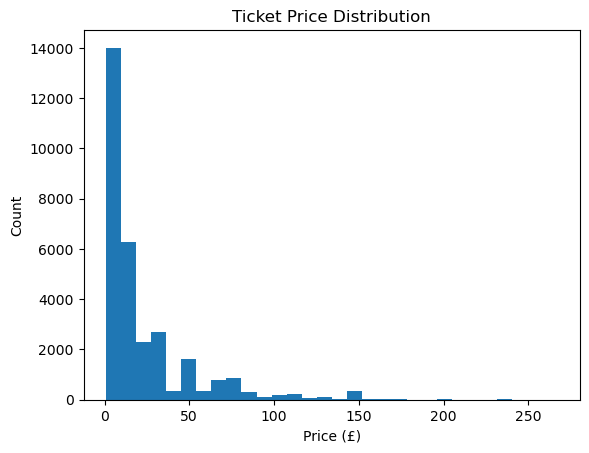

In [29]:
### Univariate Analysis

#Price Distribution
plt.hist(df['Price'], bins=30)
plt.title("Ticket Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()


In [ ]:
#Add delay in minutes column
df['Delay_Minutes'] = (df['Actual.Arrival'] - df['Scheduled.Arrival']).dt.total_seconds() / 60

df.loc[df['Journey.Status'] == "On Time", 'DelayInMinutes'] = np.nan

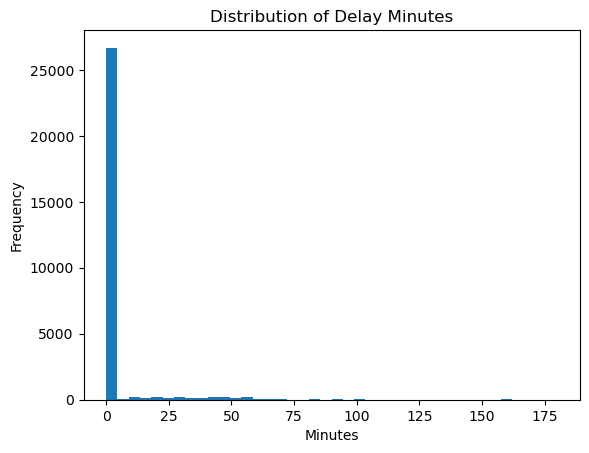

In [31]:
#Delay Distribution
df['Delay_Minutes'].dropna().plot(kind='hist', bins=40)
plt.title("Distribution of Delay Minutes")
plt.xlabel("Minutes")
plt.show()


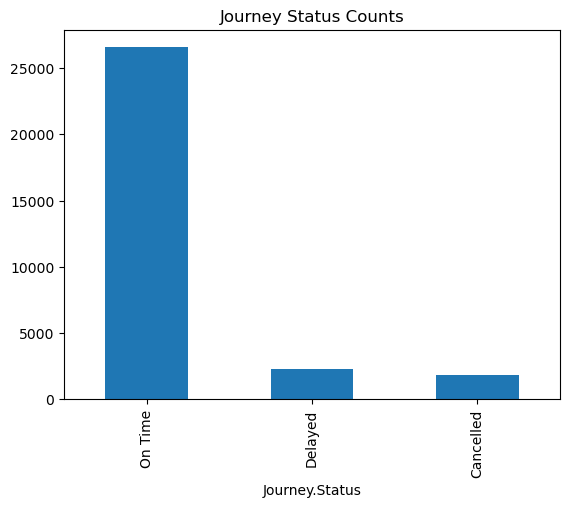

In [32]:
#Journey Status Counts
df['Journey.Status'].value_counts().plot(kind='bar')
plt.title("Journey Status Counts")
plt.show()


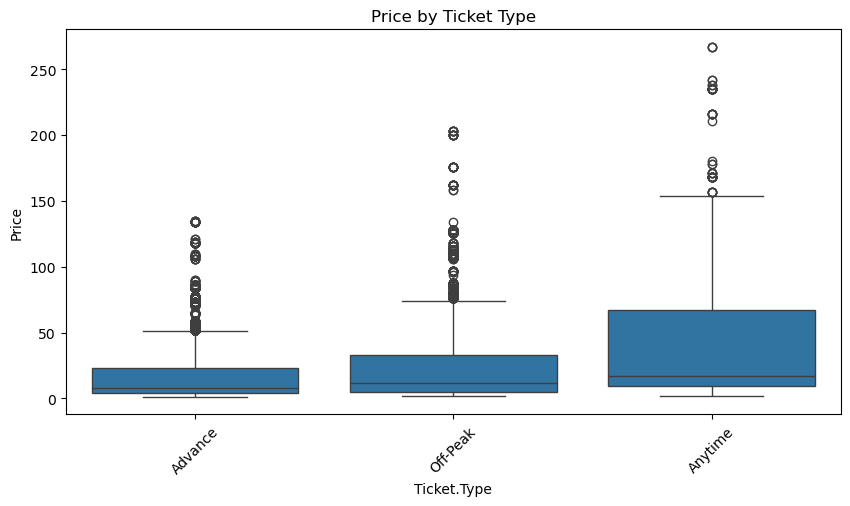

In [33]:
#Price by Ticket Type
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Ticket.Type', y='Price')
plt.xticks(rotation=45)
plt.title("Price by Ticket Type")
plt.show()


Mean ticket price by route:
Route
Manchester Piccadilly → London Paddington     113.220472
Liverpool Lime Street → London St Pancras     104.774194
Liverpool Lime Street → London Euston         103.338889
Manchester Piccadilly → London Euston         100.715655
Liverpool Lime Street → London Paddington      99.962963
Manchester Piccadilly → London St Pancras      99.562500
Reading → Liverpool Lime Street                94.125000
London Paddington → Manchester Piccadilly      93.933333
Manchester Piccadilly → London Kings Cross     90.250000
London Euston → Manchester Piccadilly          89.600334
Name: Price, dtype: float64


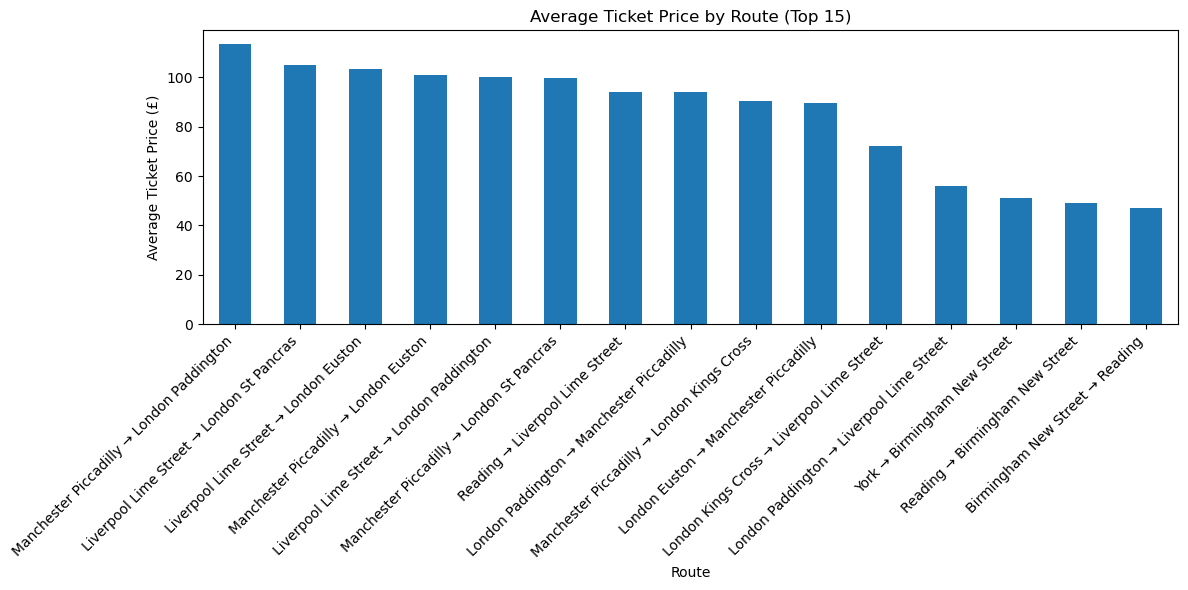

In [52]:
df["Route"] = df["Departure.Station"] + " → " + df["Arrival.Station"]
route_price = df.groupby("Route")["Price"].mean().sort_values(ascending=False)

print("Mean ticket price by route:")
print(route_price.head(10))


plt.figure(figsize=(12,6))
route_price.head(15).plot(kind="bar")
plt.title("Average Ticket Price by Route (Top 15)")
plt.xlabel("Route")
plt.ylabel("Average Ticket Price (£)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Correlation between route busyness and ticket price: -0.1268


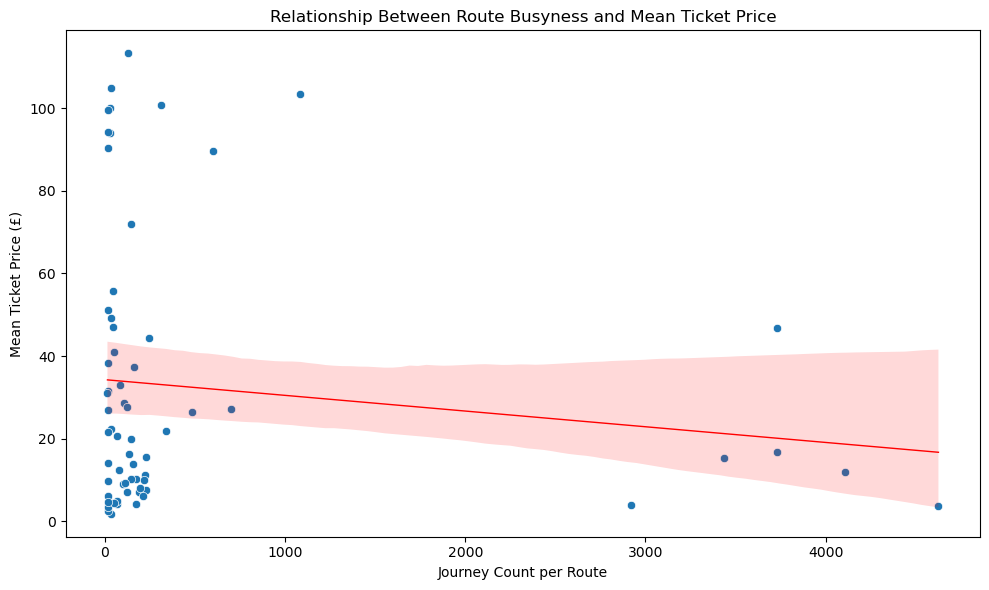

In [53]:
route_stats = df.groupby("Route").agg(
    MeanPrice=("Price", "mean"),
    JourneyCount=("Route", "count")
).reset_index()

# -------------------------------------------------------
# 3. Compute correlation coefficient
# -------------------------------------------------------
corr = route_stats["MeanPrice"].corr(route_stats["JourneyCount"])
print(f"Correlation between route busyness and ticket price: {corr:.4f}")

# -------------------------------------------------------
# 4. Scatter plot
# -------------------------------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=route_stats,
    x="JourneyCount",
    y="MeanPrice"
)

# Add trendline for visual correlation
sns.regplot(
    data=route_stats,
    x="JourneyCount",
    y="MeanPrice",
    scatter=False,
    color="red",
    line_kws={"linewidth": 1}
)

plt.title("Relationship Between Route Busyness and Mean Ticket Price")
plt.xlabel("Journey Count per Route")
plt.ylabel("Mean Ticket Price (£)")
plt.tight_layout()
plt.show()

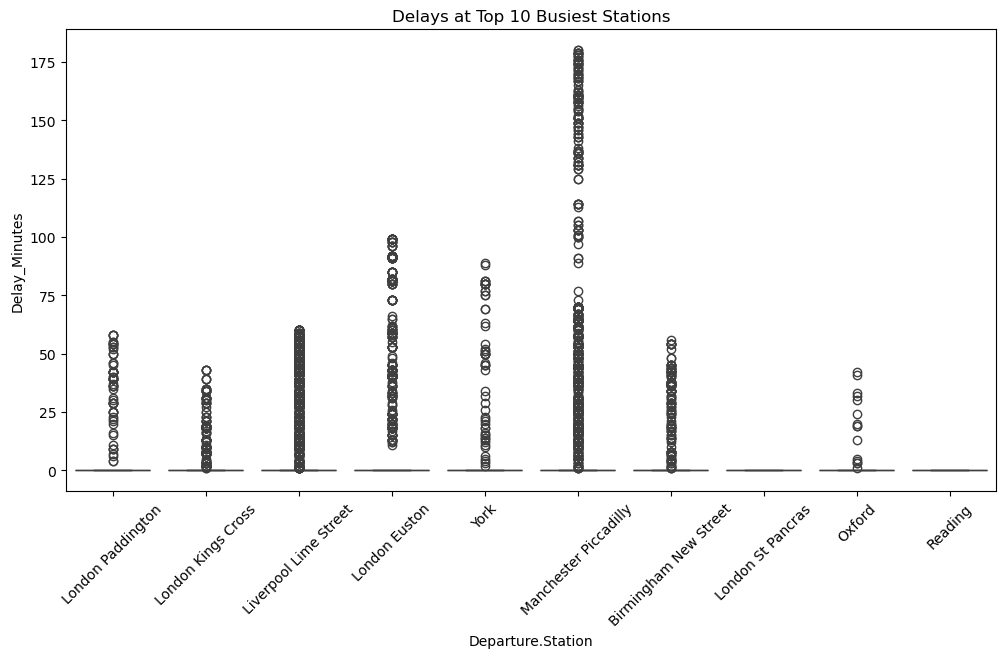

In [34]:
plt.figure(figsize=(12,6))
top_departures = df['Departure.Station'].value_counts().head(10).index

sns.boxplot(
    data=df[df['Departure.Station'].isin(top_departures)],
    x='Departure.Station', y='Delay_Minutes'
)
plt.xticks(rotation=45)
plt.title("Delays at Top 10 Busiest Stations")
plt.show()


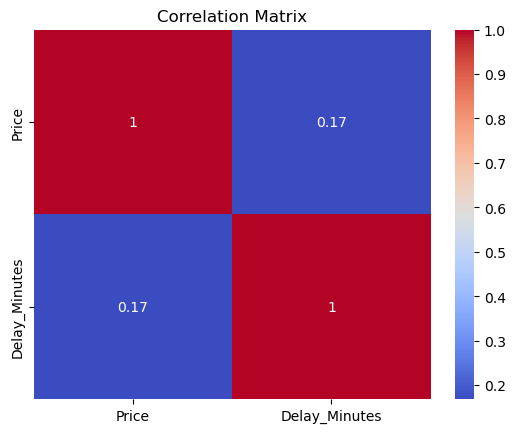

In [35]:
#Correlation Matrix price and delay
numeric_df = df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


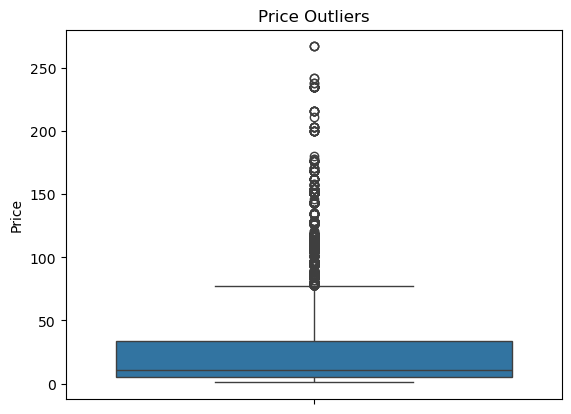

In [36]:
#outliers
#price outliers
sns.boxplot(df['Price'])
plt.title("Price Outliers")
plt.show()


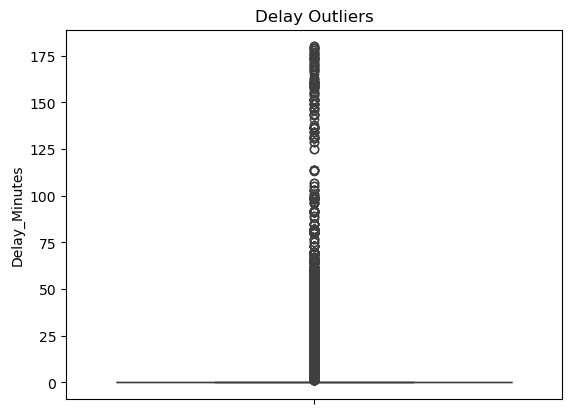

In [37]:
#delay outliers
sns.boxplot(df['Delay_Minutes'])
plt.title("Delay Outliers")
plt.show()


In [38]:
#station level analysis
#most frequent routes
df['Route'] = df['Departure.Station'] + " → " + df['Arrival.Station']
df['Route'].value_counts().head(10)




Route
Manchester Piccadilly → Liverpool Lime Street    4626
London Euston → Birmingham New Street            4109
London Kings Cross → York                        3731
London Paddington → Reading                      3728
London St Pancras → Birmingham New Street        3436
Liverpool Lime Street → Manchester Piccadilly    2918
Liverpool Lime Street → London Euston            1080
Birmingham New Street → London St Pancras         701
London Euston → Manchester Piccadilly             598
London Paddington → Oxford                        485
Name: count, dtype: int64

In [39]:
#delay by route
df.groupby('Route')['Delay_Minutes'].mean().sort_values().head(100)

Route
Birmingham New Street → Coventry                  0.000000
Birmingham New Street → Liverpool Lime Street     0.000000
Birmingham New Street → London Kings Cross        0.000000
Birmingham New Street → London Paddington         0.000000
Birmingham New Street → Nuneaton                  0.000000
                                                   ...    
Liverpool Lime Street → London Paddington        18.481481
Manchester Piccadilly → London Euston            18.503205
Liverpool Lime Street → London Euston            29.061162
London Euston → York                             35.125000
Manchester Piccadilly → Leeds                    65.241135
Name: Delay_Minutes, Length: 64, dtype: float64

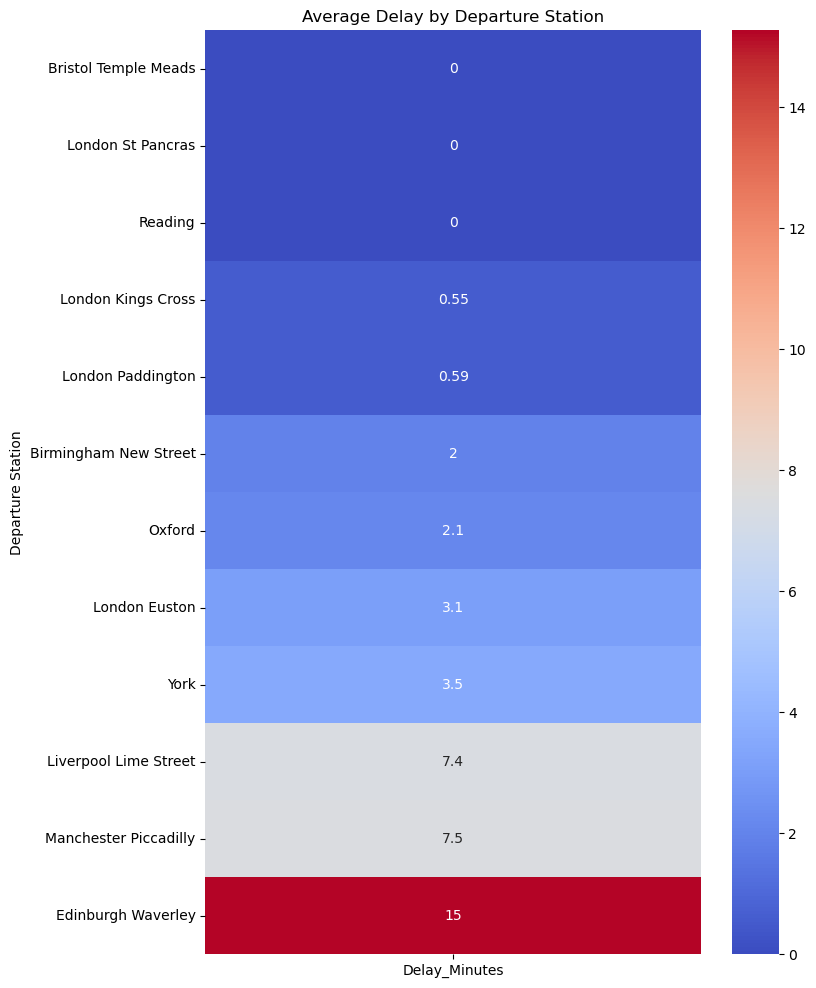

In [40]:
delay_departure = (
    df.groupby('Departure.Station')['Delay_Minutes']
    .mean()
    .sort_values()
    .to_frame()
)

plt.figure(figsize=(8,12))
sns.heatmap(delay_departure, annot=True, cmap='coolwarm')
plt.title("Average Delay by Departure Station")
plt.ylabel("Departure Station")
plt.show()


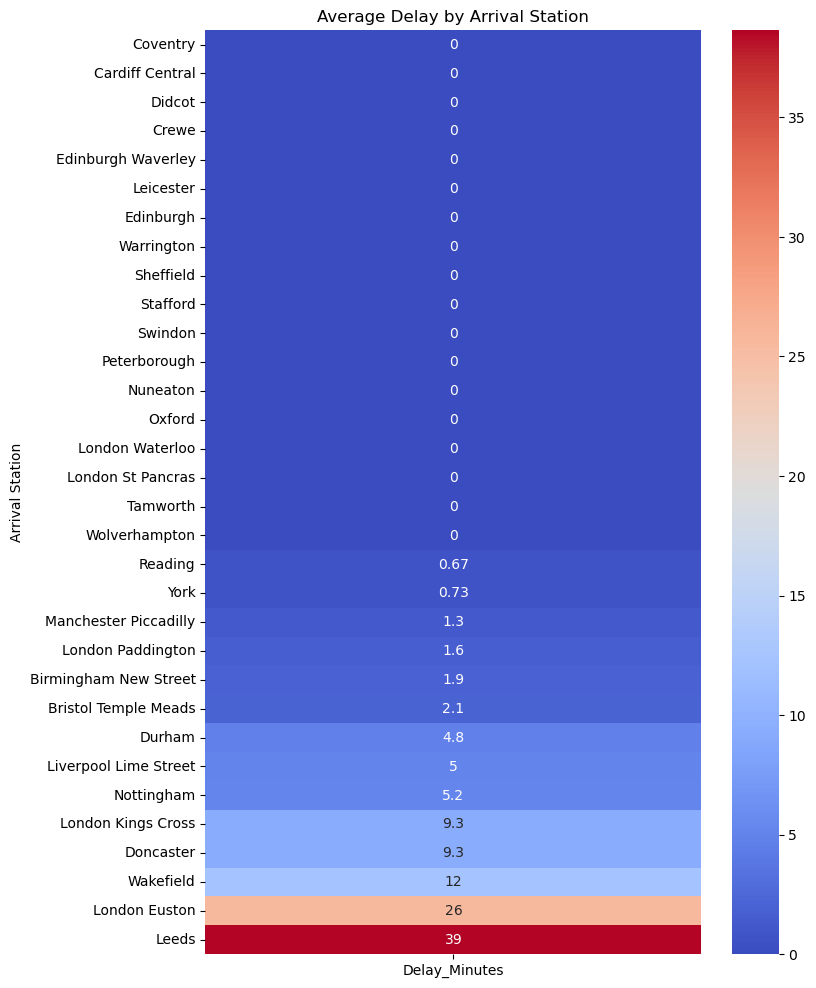

In [54]:
delay_arrivals = (
    df.groupby('Arrival.Station')['Delay_Minutes']
    .mean()
    .sort_values()
    .to_frame()
)

plt.figure(figsize=(8,12))
sns.heatmap(delay_arrivals, annot=True, cmap='coolwarm')
plt.title("Average Delay by Arrival Station")
plt.ylabel("Arrival Station")
plt.show()

In [41]:
#Q4

# Restrict to journeys that are NOT "On Time"
df_late = df[df['Journey.Status'] != "On Time"].copy()

# Add "MediumPrice"
#median_price = df['Price'].median()

df_late['MediumPrice'] = df_late['Price'].apply(lambda x: 10 < x <= 30)

# Save filtered dataset
df_late.to_csv('/Users/tomiwaodulaja/Desktop/Masters/DATA70121/Assessment1/MavenRail_filtered_with_MediumPrice.csv', index=False)

print("Filtered dataset created with MediumPrice column.")
print(df_late.head())


Filtered dataset created with MediumPrice column.
   Payment.Method Railcard Ticket.Class Ticket.Type  Price  \
1     Credit Card    Adult     Standard     Advance     23   
8     Credit Card      NaN     Standard     Advance     37   
20     Debit Card    Adult     Standard     Advance      7   
26    Credit Card   Senior  First Class     Advance     34   
38    Credit Card      NaN     Standard     Advance      7   

        Departure.Station        Arrival.Station           Departure  \
1      London Kings Cross                   York 2024-01-01 09:45:00   
8           London Euston                   York 2024-01-01 00:00:00   
20  Birmingham New Street  Manchester Piccadilly 2024-01-01 11:15:00   
26                 Oxford   Bristol Temple Meads 2024-01-01 14:15:00   
38          London Euston  Birmingham New Street 2024-01-02 02:15:00   

     Scheduled.Arrival      Actual.Arrival Journey.Status Reason.for.Delay  \
1  2024-01-01 11:35:00 2024-01-01 11:40:00        Delayed   Signal

In [ ]:
#set Refund.Request: Yes = 1, No = 0
df_late['Refund_Flag'] = df_late['Refund.Request'].map({'Yes': 1, 'No': 0})


# 2. Fit logistic regression model


# Predictor (MediumPrice) needs to be numeric (0/1)
X = df_late['MediumPrice'].astype(int)
X = sm.add_constant(X)  # add intercept

# Target variable
y = df_late['Refund_Flag']

# Fit model
model = sm.Logit(y, X).fit()

print(model.summary())


# 3. Use fitted model to predict probabilities


# Extract coefficients
b0 = model.params['const']
b1 = model.params['MediumPrice']

def logistic(z):
    return 1 / (1 + np.exp(-z))

# CASE 1: Ticket price = £5
# MediumPrice = False → 0
z_5 = b0 + b1 * 0
p_5 = logistic(z_5)

# CASE 2: Ticket price = £25
# MediumPrice = True → 1
z_25 = b0 + b1 * 1
p_25 = logistic(z_25)

print("\nPredicted probability of refund request:")
print(f"• For £5 ticket (MediumPrice = 0): {p_5:.4f}")
print(f"• For £25 ticket (MediumPrice = 1): {p_25:.4f}")

Optimization terminated successfully.
         Current function value: 0.577033
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Refund_Flag   No. Observations:                 4121
Model:                          Logit   Df Residuals:                     4119
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Nov 2025   Pseudo R-squ.:                0.003307
Time:                        19:04:42   Log-Likelihood:                -2378.0
converged:                       True   LL-Null:                       -2385.8
Covariance Type:            nonrobust   LLR p-value:                 7.124e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0841      0.040    -27.402      0.000      -1.162      -1.007
MediumPrice     0.3541    

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer


# 1. Load datasets

df = pd.read_csv("MavenRail_cleaned2.csv")
df_pred = pd.read_csv("ToPredict_with_refund.csv")


# 2. Feature engineering

# Encode refund variable
df['Refund_Flag'] = df['Refund.Request'].map({'Yes': 1, 'No': 0})

# Convert times + calculate delays
for d in [df, df_pred]:
    d['Scheduled.Arrival'] = pd.to_datetime(d['Scheduled.Arrival'], errors='coerce')
    d['Actual.Arrival'] = pd.to_datetime(d['Actual.Arrival'], errors='coerce')
    d['Delay_Minutes'] = (d['Actual.Arrival'] - d['Scheduled.Arrival']).dt.total_seconds() / 60


# 3. Select explanatory variables

features = [
    "Price", 
    "Ticket.Type", 
    "Ticket.Class", 
    "Railcard", 
    "Journey.Status", 
    "Delay_Minutes"
]

X = df[features]
y = df['Refund_Flag']
X_pred = df_pred[features]


# 4. Preprocessing with IMPUTATION


categorical_features = ["Ticket.Type", "Ticket.Class", "Railcard", "Journey.Status"]
numeric_features = ["Price", "Delay_Minutes"]

preprocess = ColumnTransformer(
    transformers=[
        ("categorical",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore"))
         ]),
         categorical_features
        ),
        ("numeric",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="median"))
         ]),
         numeric_features
        )
    ]
)


# 5. Logistic Regression Model

log_reg = LogisticRegression(max_iter=2000)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

# Train model
pipeline.fit(X, y)


# 6. Predict refund probabilities

df_pred["Refund_Probability"] = pipeline.predict_proba(X_pred)[:, 1]

# Save output
output_path = "Refund_Predictions_Logistic.csv"
df_pred.to_csv(output_path, index=False)

print("Predictions saved to:", output_path)
print(df_pred[["Refund_Probability"]].head())


Predictions saved to: Refund_Predictions_Logistic.csv
   Refund_Probability
0            0.000201
1            0.000209
2            0.352582
3            0.784001
4            0.393096
